# Momentum base trading(?) 
In this notebook, we explore momentum based trading patterns

(Mis)Adevnture #1: Since we are looking for signals, we could originally just look at aggregate stocks (e.g. S&P500). If lagged features
are showing some sort of signal for a given aggregate stock, we filter down to that stock see if there was a driving stock for the aggregate stock we observed.

In [18]:
!uv pip install yfinance scikit-learn matplotlib seaborn skfolio riskfolio-lib pandas numpy

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler


import matplotlib.cm as cm
import matplotlib.colors as mcolors

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from skfolio import Portfolio


  TOML parse error at line 7, column 10
    |
  7 | [tool.uv.dependency-groups.default]
    |          ^^^^^^^^^^^^^^^^^
  unknown field `dependency-groups`, expected one of `required-version`, `native-tls`, `offline`, `no-cache`, `cache-dir`, `preview`, `python-preference`, `python-downloads`, `concurrent-downloads`, `concurrent-builds`, `concurrent-installs`, `index`, `index-url`, `extra-index-url`, `no-index`, `find-links`, `index-strategy`, `keyring-provider`, `allow-insecure-host`, `resolution`, `prerelease`, `fork-strategy`, `dependency-metadata`, `config-settings`, `no-build-isolation`, `no-build-isolation-package`, `exclude-newer`, `link-mode`, `compile-bytecode`, `no-sources`, `upgrade`, `upgrade-package`, `reinstall`, `reinstall-package`, `no-build`, `no-build-package`, `no-binary`, `no-binary-package`, `python-install-mirror`, `pypy-install-mirror`, `publish-url`, `trusted-publishing`, `check-url`, `pip`, `cache-keys`, `override-dependencies`, `constraint-dependencies`, `env

In [23]:
import yfinance as yf

tickers = ["SPY", "XLE", "XOM", "CVX", "OXY", "COP"]
"""
SPY: SPDR S&P 500 ETF Trust, Tracks the S&P 500 index representing large-cap U.S. stocks.
XLE: S&P 500 energy ETF.
XOM: Exxon Mobil Corporation Major integrated oil and gas company with global operations.
CVX: Chevron Corporation, Large U.S. oil company involved in exploration, production, and refining.
OXY: Oil & gas producer.
COP: Oil & gas explorer.
"""

data = yf.download(tickers, start="2023-01-01")

print(data.columns)  # This shows the structure
print(data.head())

/var/folders/kw/2qkht0_n5ksdwhs1fsbt95pw0000gn/T/ipykernel_13651/3274610579.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2023-01-01")
[*********************100%***********************]  6 of 6 completed

MultiIndex([( 'Close', 'COP'),
            ( 'Close', 'CVX'),
            ( 'Close', 'OXY'),
            ( 'Close', 'SPY'),
            ( 'Close', 'XLE'),
            ( 'Close', 'XOM'),
            (  'High', 'COP'),
            (  'High', 'CVX'),
            (  'High', 'OXY'),
            (  'High', 'SPY'),
            (  'High', 'XLE'),
            (  'High', 'XOM'),
            (   'Low', 'COP'),
            (   'Low', 'CVX'),
            (   'Low', 'OXY'),
            (   'Low', 'SPY'),
            (   'Low', 'XLE'),
            (   'Low', 'XOM'),
            (  'Open', 'COP'),
            (  'Open', 'CVX'),
            (  'Open', 'OXY'),
            (  'Open', 'SPY'),
            (  'Open', 'XLE'),
            (  'Open', 'XOM'),
            ('Volume', 'COP'),
            ('Volume', 'CVX'),
            ('Volume', 'OXY'),
            ('Volume', 'SPY'),
            ('Volume', 'XLE'),
            ('Volume', 'XOM')],
           names=['Price', 'Ticker'])
Price            Close         

In [24]:
def download_data(tickers: list[str], start: str = "2023-01-01") -> pd.DataFrame:
    """
    Downloads closing prices from Yahoo Finance.
    Uses 'Close' if 'Adj Close' is not available.
    """
    raw = yf.download(tickers, start=start, auto_adjust=False)

    # yfinance sometimes changes the column schema depending on the date range
    if isinstance(raw.columns, pd.MultiIndex):
        if "Adj Close" in raw.columns.get_level_values(0):
            return raw["Adj Close"].dropna(how="all", axis=1)
        elif "Close" in raw.columns.get_level_values(0):
            return raw["Close"].dropna(how="all", axis=1)
        else:
            raise ValueError("Neither 'Adj Close' nor 'Close' found in data.")
    else:
        # Single ticker format
        if "Adj Close" in raw.columns:
            return raw["Adj Close"].to_frame()
        elif "Close" in raw.columns:
            return raw["Close"].to_frame()
        else:
            raise ValueError("Neither 'Adj Close' nor 'Close' found in single-ticker data.")



def resample_data(data: pd.DataFrame) -> dict[str, pd.DataFrame]:
    """
    Resamples data into daily, weekly, monthly, and yearly frequencies.
    """
    return {
        "daily": data.dropna(),
        "weekly": data.resample("W").last().dropna(),
        "monthly": data.resample("M").last().dropna(),
        "yearly": data.resample("Y").last().dropna(),
    }


def prepare_lagged_features(data: pd.DataFrame, lags: list[int]) -> tuple[pd.DataFrame, pd.Series]:
    """
    Builds lagged return features and a binary momentum target.
    """
    returns = data.pct_change().dropna()
    features = {}
    for lag in lags:
        features[f"lag_{lag}"] = returns.shift(lag)

    X = pd.concat(features, axis=1).dropna()
    y = (returns > 0).mean(axis=1).loc[X.index]  # Binary signal: majority of assets positive
    y = (y > 0.5).astype(int)  # Target: 1 if majority of assets moved up

    return X, y


def train_classifier(X: pd.DataFrame, y: pd.Series) -> float:
    """
    Trains a Random Forest classifier using time-series cross-validation.
    """
    X_scaled = StandardScaler().fit_transform(X)
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    cv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, X_scaled, y.values, cv=cv, scoring="accuracy")
    return scores.mean()

def plot_cumulative_returns(data: pd.DataFrame, title: str, color_map: str) -> None:
    """
    Plots cumulative returns using a Viridis color map with enhanced styling.
    """
    cum_returns = (1 + data.pct_change().dropna()).cumprod()
    num_assets = len(cum_returns.columns)
    cmap = cm.get_cmap(f"{color_map}", num_assets)
    colors = [cmap(i) for i in range(num_assets)]

    fig, ax = plt.subplots(figsize=(14, 7))

    for i, col in enumerate(cum_returns.columns):
        ax.plot(cum_returns.index, cum_returns[col], label=col, color=colors[i], linewidth=2.5)

    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_ylabel("Cumulative Return", fontsize=14)
    ax.set_xlabel("Date", fontsize=14)

    ax.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)
    ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
    ax.legend(loc="upper left", fontsize="medium", frameon=False, ncol=2)

    plt.tight_layout()
    plt.show()



def evaluate_with_skfolio(returns: pd.Series, label: str) -> None:
    """
    Uses skfolio to evaluate strategy returns.
    """
    port = Portfolio(X=returns.values.reshape(-1, 1), weights=[1])
    cumulative = (1 + pd.Series(port.returns, index=returns.index)).cumprod()

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(cumulative, label=label)
    ax.set_title(f"{label} - Cumulative Return (skfolio)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Return")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"{label} Sharpe Ratio:", round(port.sharpe_ratio, 2))
    print(f"{label} Max Drawdown:", round(port.max_drawdown, 2))
    print(f"{label} CVaR 95%:", round(port.cvar, 2))

[*********************100%***********************]  6 of 6 completed
/var/folders/kw/2qkht0_n5ksdwhs1fsbt95pw0000gn/T/ipykernel_13651/2714243446.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "monthly": data.resample("M").last().dropna(),
/var/folders/kw/2qkht0_n5ksdwhs1fsbt95pw0000gn/T/ipykernel_13651/2714243446.py:35: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "yearly": data.resample("Y").last().dropna(),



=== DAILY DATA ===
Daily model accuracy: 0.500


/var/folders/kw/2qkht0_n5ksdwhs1fsbt95pw0000gn/T/ipykernel_13651/2714243446.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(f"{color_map}", num_assets)


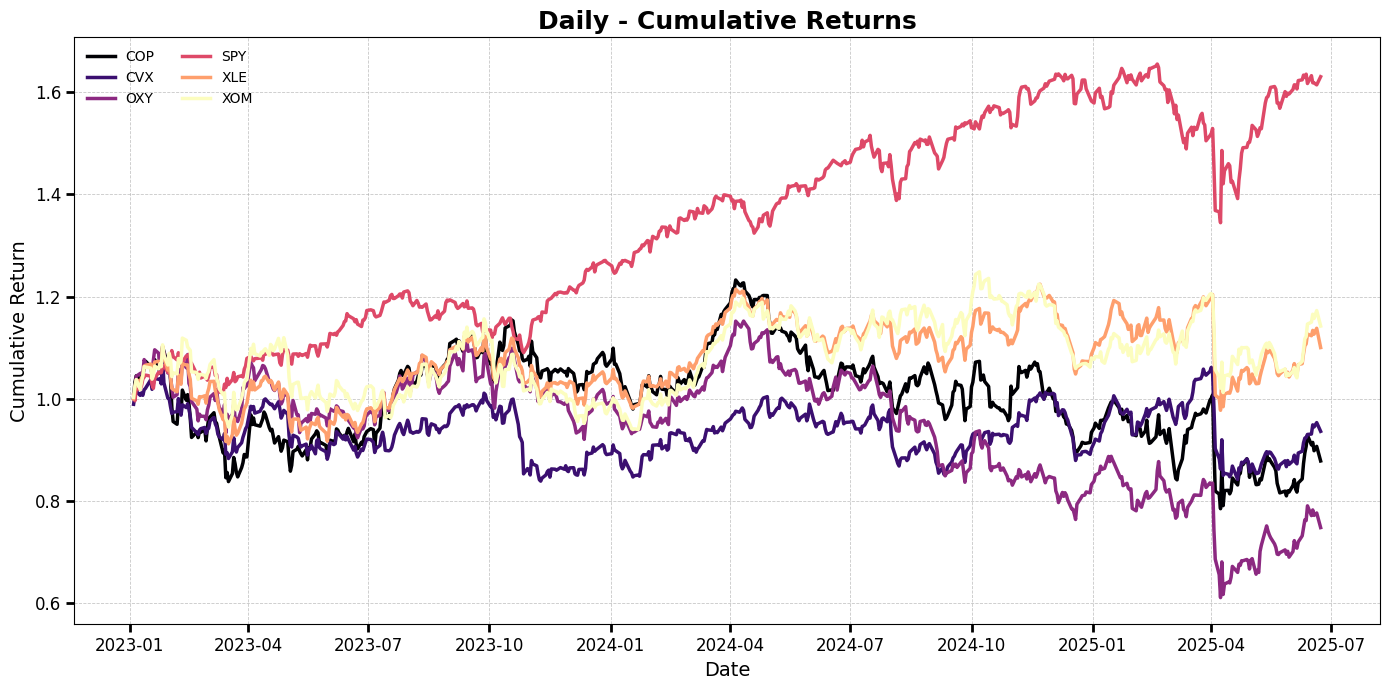

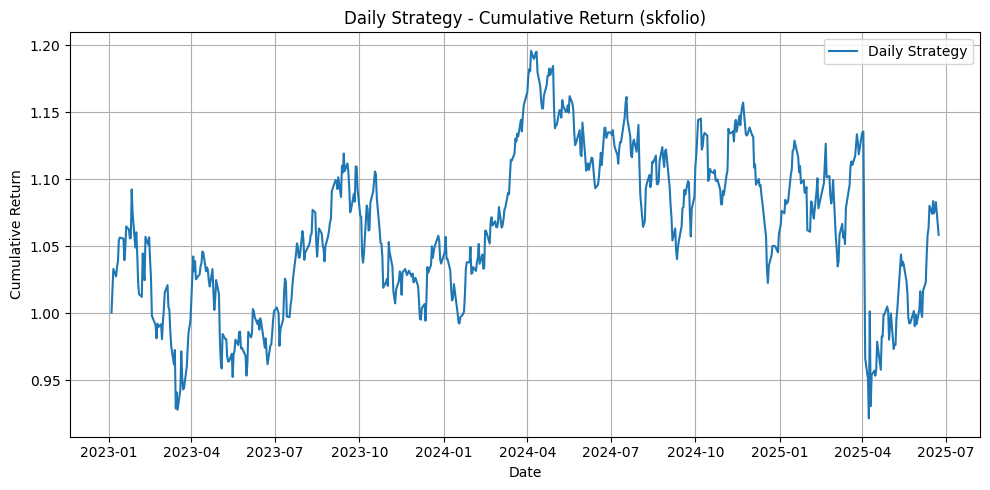

Daily Strategy Sharpe Ratio: 0.01
Daily Strategy Max Drawdown: 0.24
Daily Strategy CVaR 95%: 0.03

=== WEEKLY DATA ===
Weekly model accuracy: 0.490


/var/folders/kw/2qkht0_n5ksdwhs1fsbt95pw0000gn/T/ipykernel_13651/2714243446.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(f"{color_map}", num_assets)


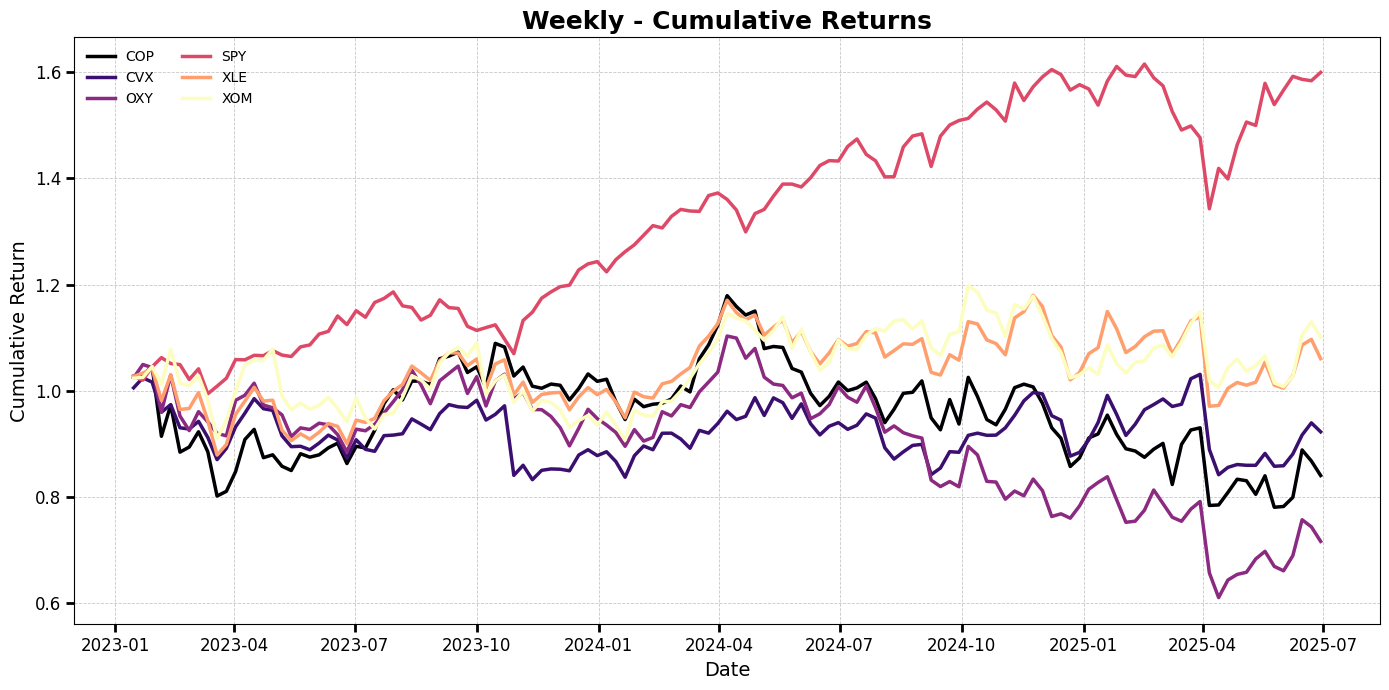

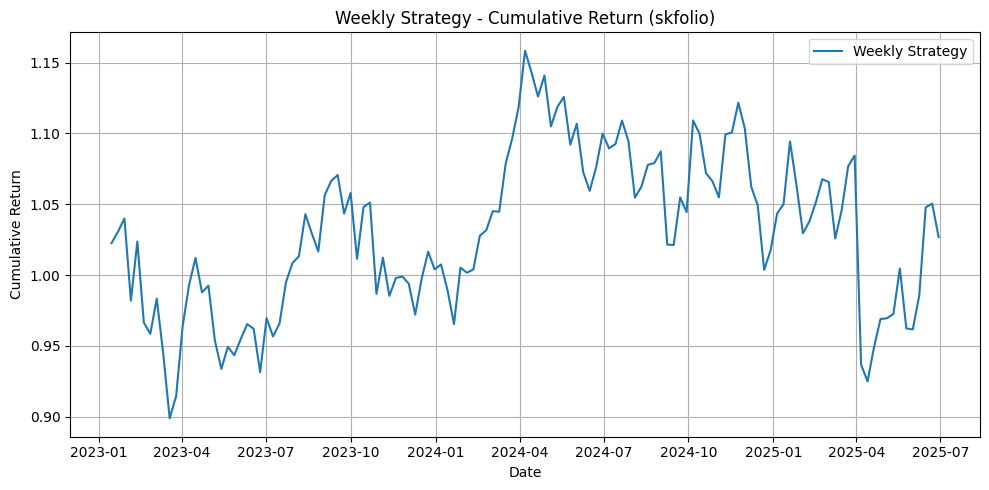

Weekly Strategy Sharpe Ratio: 0.02
Weekly Strategy Max Drawdown: 0.2
Weekly Strategy CVaR 95%: 0.07

=== MONTHLY DATA ===
Monthly model accuracy: 0.600


/var/folders/kw/2qkht0_n5ksdwhs1fsbt95pw0000gn/T/ipykernel_13651/2714243446.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(f"{color_map}", num_assets)


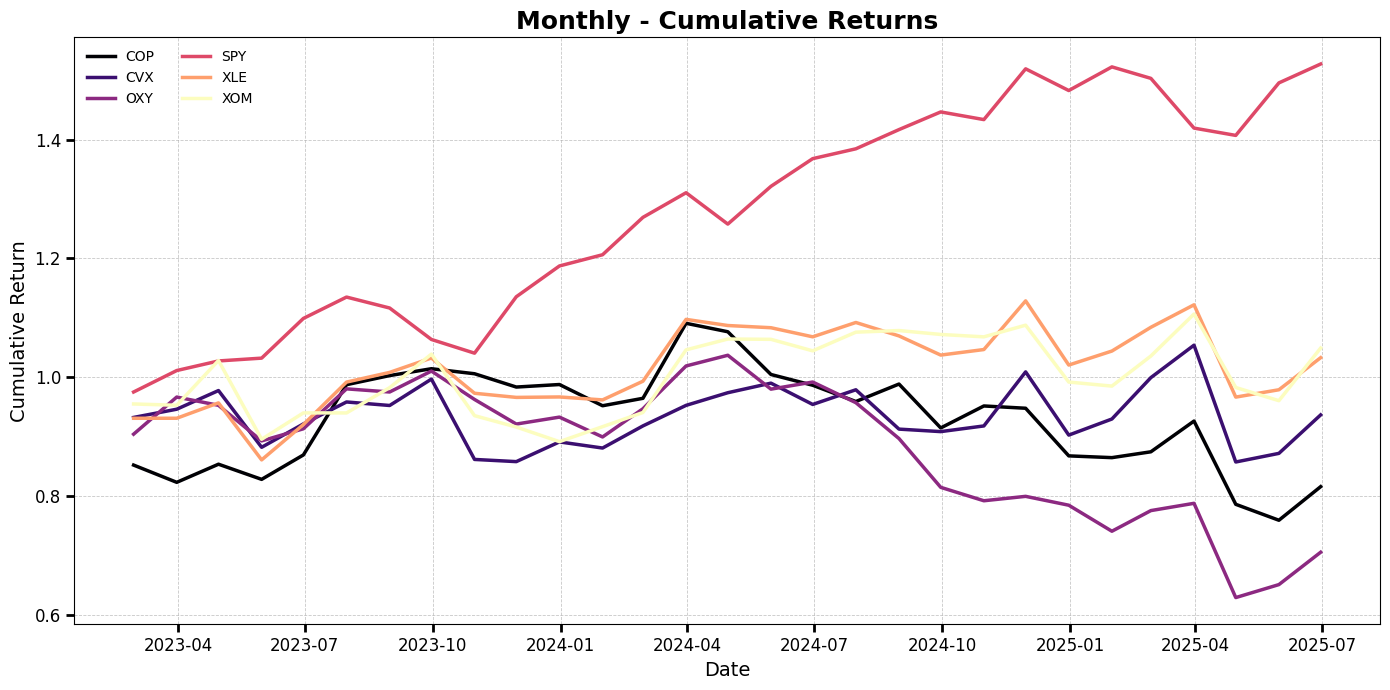

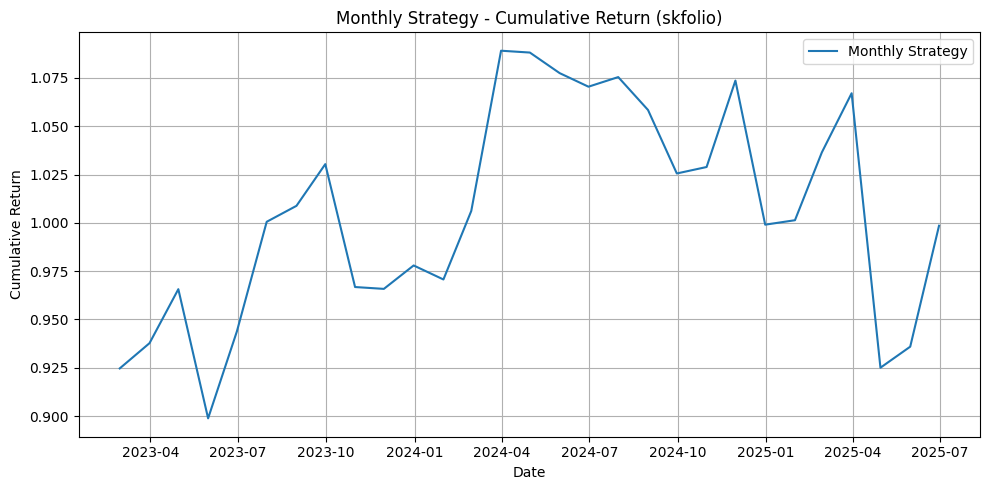

Monthly Strategy Sharpe Ratio: 0.02
Monthly Strategy Max Drawdown: 0.15
Monthly Strategy CVaR 95%: 0.12

=== YEARLY DATA ===


ValueError: Found array with 0 sample(s) (shape=(0, 24)) while a minimum of 1 is required by StandardScaler.

In [25]:

def main() -> None:
    """
    Main routine to run momentum-based strategy and evaluate it.
    """
    tickers = ["SPY", "XLE", "XOM", "CVX", "OXY", "COP"]
    lags = [1, 2, 3, 6]

    price_data = download_data(tickers)
    data_by_freq = resample_data(price_data)

    for freq, data in data_by_freq.items():
        print(f"\n=== {freq.upper()} DATA ===")
        X, y = prepare_lagged_features(data, lags)
        accuracy = train_classifier(X, y)
        print(f"{freq.capitalize()} model accuracy: {accuracy:.3f}")

        plot_cumulative_returns(data, f"{freq.capitalize()} - Cumulative Returns", color_map="magma")

        daily_mean_returns = data.pct_change().mean(axis=1).dropna()
        evaluate_with_skfolio(daily_mean_returns, f"{freq.capitalize()} Strategy")


if __name__ == "__main__":
    main()


In [27]:
data.columns

MultiIndex([( 'Close', 'COP'),
            ( 'Close', 'CVX'),
            ( 'Close', 'OXY'),
            ( 'Close', 'SPY'),
            ( 'Close', 'XLE'),
            ( 'Close', 'XOM'),
            (  'High', 'COP'),
            (  'High', 'CVX'),
            (  'High', 'OXY'),
            (  'High', 'SPY'),
            (  'High', 'XLE'),
            (  'High', 'XOM'),
            (   'Low', 'COP'),
            (   'Low', 'CVX'),
            (   'Low', 'OXY'),
            (   'Low', 'SPY'),
            (   'Low', 'XLE'),
            (   'Low', 'XOM'),
            (  'Open', 'COP'),
            (  'Open', 'CVX'),
            (  'Open', 'OXY'),
            (  'Open', 'SPY'),
            (  'Open', 'XLE'),
            (  'Open', 'XOM'),
            ('Volume', 'COP'),
            ('Volume', 'CVX'),
            ('Volume', 'OXY'),
            ('Volume', 'SPY'),
            ('Volume', 'XLE'),
            ('Volume', 'XOM')],
           names=['Price', 'Ticker'])

/var/folders/kw/2qkht0_n5ksdwhs1fsbt95pw0000gn/T/ipykernel_13651/538630728.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(sector_etfs, start=start)["Close"]
[*********************100%***********************]  12 of 12 completed
/var/folders/kw/2qkht0_n5ksdwhs1fsbt95pw0000gn/T/ipykernel_13651/538630728.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_features = features.resample("M").last()
/var/folders/kw/2qkht0_n5ksdwhs1fsbt95pw0000gn/T/ipykernel_13651/538630728.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = prices.pct_change().resample("M").sum()


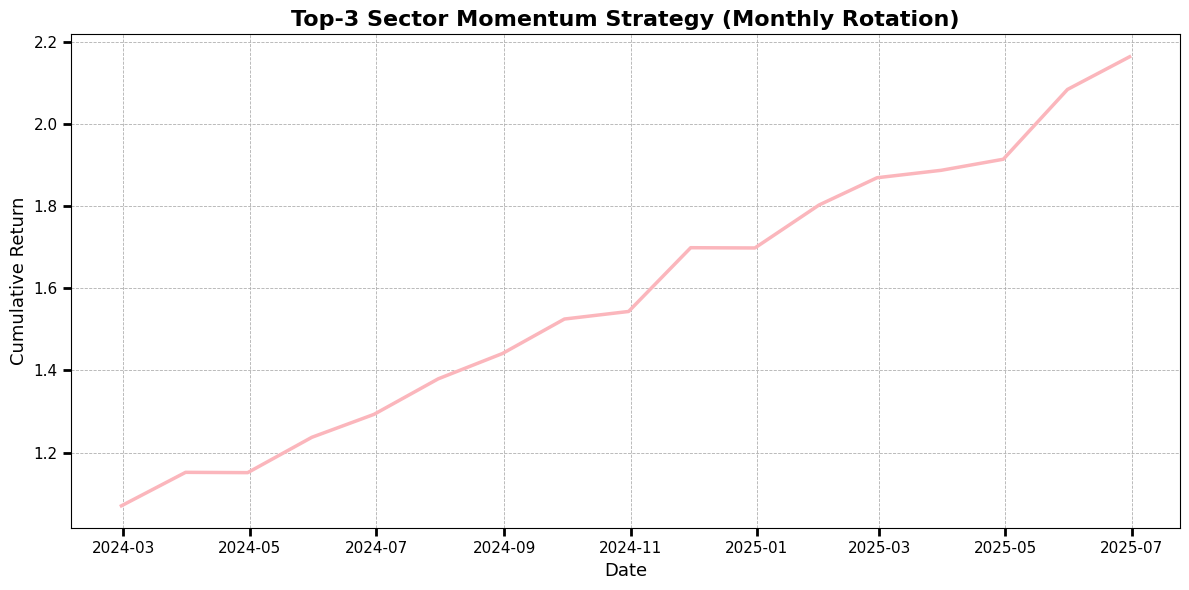

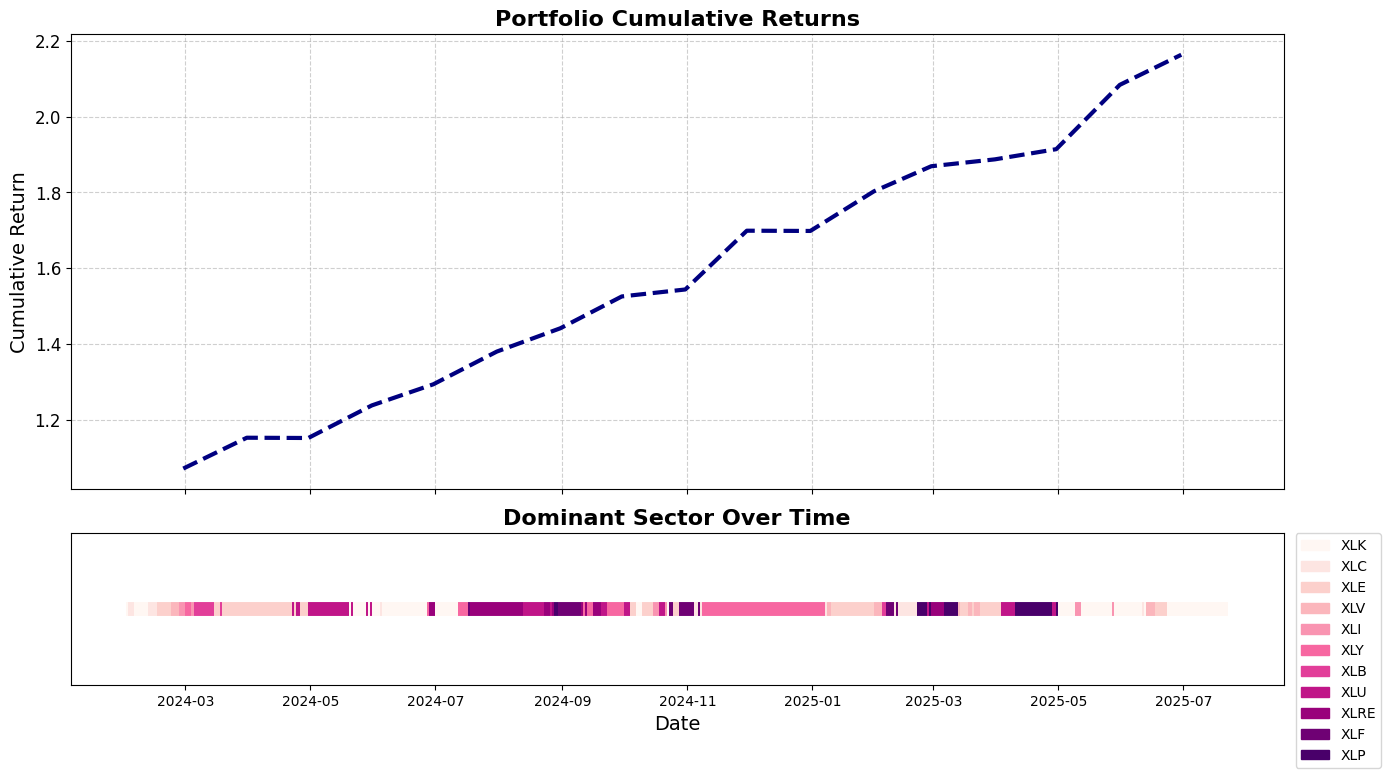

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from skfolio import Portfolio

def download_sector_etfs(start: str = "2024-01-01") -> pd.DataFrame:
    """
    Downloads closing prices for key sector ETFs to represent aggregate sector performance.
    """
    sector_etfs = [
        "SPY", "XLE", "XLK", "XLF", "XLV", "XLI",
        "XLP", "XLY", "XLU", "XLB", "XLRE", "XLC"
    ]
    data = yf.download(sector_etfs, start=start)["Close"]
    return data.dropna(how="all", axis=1)


def compute_rolling_features(prices: pd.DataFrame, window: int = 21) -> pd.DataFrame:
    """
    Computes rolling momentum (returns) and volatility features.
    """
    log_returns = np.log(prices / prices.shift(1))
    momentum = log_returns.rolling(window=window).sum()
    volatility = log_returns.rolling(window=window).std()
    features = momentum.subtract(volatility)
    return features.dropna()


def simulate_momentum_strategy(prices: pd.DataFrame, features: pd.DataFrame, top_n: int = 3) -> pd.Series:
    """
    Simulates monthly sector rotation based on top-N momentum scores.
    """
    monthly_features = features.resample("M").last()
    monthly_returns = prices.pct_change().resample("M").sum()

    portfolio_returns = {}

    for date in monthly_features.index:
        if date not in monthly_returns.index:
            continue

        top_sectors = monthly_features.loc[date].nlargest(top_n).index
        next_return = monthly_returns.loc[date, top_sectors].mean()
        portfolio_returns[date] = next_return

    return pd.Series(portfolio_returns)

def plot_cumulative(series: pd.Series, title: str) -> None:
    """
    Plots cumulative returns using a viridis-colored line.
    """
    cum_returns = (1 + series).cumprod()
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(cum_returns.index, cum_returns.values, linewidth=2.5, color=plt.cm.RdPu_r(0.7))
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Date", fontsize=13)
    ax.set_ylabel("Cumulative Return", fontsize=13)
    ax.grid(True, linestyle='--', linewidth=0.6)
    ax.tick_params(axis="both", labelsize=11, width=2, length=6)
    plt.tight_layout()
    plt.show()

# def plot_sector_cumulative(prices: pd.DataFrame) -> None:
#     cum_returns = (1 + prices.pct_change().dropna()).cumprod()
#     num_assets = len(prices.columns)
#     cmap = plt.cm.viridis
#     colors = [cmap(i / num_assets) for i in range(num_assets)]

#     fig, ax = plt.subplots(figsize=(14, 7))
#     for i, col in enumerate(prices.columns):
#         ax.plot(cum_returns.index, cum_returns[col], label=col, color=colors[i], linewidth=2.5)

#     ax.set_title("Sector ETFs Cumulative Returns", fontsize=16, fontweight='bold')
#     ax.set_xlabel("Date", fontsize=14)
#     ax.set_ylabel("Cumulative Return", fontsize=14)
#     ax.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)
#     ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
#     ax.legend(loc='upper left', fontsize='small', ncol=2)
#     plt.tight_layout()
#     plt.show()


def evaluate_portfolio(perf: pd.Series) -> None:
    """
    Evaluates a portfolio using skfolio risk metrics.
    """
    port = Portfolio(X=perf.values.reshape(-1, 1), weights=[1])
    print("Sharpe Ratio:", round(port.sharpe_ratio, 2))
    print("Max Drawdown:", round(port.max_drawdown, 2))
    print("CVaR (95%):", round(port.cvar, 2))

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

def plot_strategy_with_dominance(portfolio_returns: pd.Series, features: pd.DataFrame) -> None:
    """
    portfolio_returns: pd.Series of portfolio returns indexed by date
    features: pd.DataFrame with momentum scores per sector indexed by date
    
    Plots cumulative returns + timeline of dominant sectors.
    """

    # Identify dominant sector at each rebalance date (max momentum score)
    dominant_sector = features.idxmax(axis=1)

    # Compute cumulative returns
    cum_returns = (1 + portfolio_returns).cumprod()

    # Setup plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # --- Plot cumulative returns ---
    ax1.plot(cum_returns.index, cum_returns.values, color='navy', linewidth=3, ls='--')
    ax1.set_title("Portfolio Cumulative Returns", fontsize=16, fontweight='bold')
    ax1.set_ylabel("Cumulative Return", fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    # --- Plot dominance timeline ---
    sectors = dominant_sector.unique()
    # colors = plt.cm.tab20.colors  # up to 20 distinct colors
    # color_map = {sector: colors[i % 20] for i, sector in enumerate(sectors)}
    cmap = plt.get_cmap("RdPu")

    # Sample colors evenly spaced in the colormap
    n_sectors = len(sectors)
    colors = [cmap(i / (n_sectors - 1)) for i in range(n_sectors)]
    color_map = dict(zip(sectors, colors))

    # Plot colored line segments per period
    dates = dominant_sector.index.to_list()
    for i in range(len(dates) - 1):
        start = dates[i]
        end = dates[i + 1]
        sector = dominant_sector.iloc[i]
        ax2.hlines(1, start, end, colors=color_map[sector], linewidth=10)

    # Add last segment till end
    ax2.hlines(1, dates[-1], dates[-1] + pd.Timedelta(days=30), colors=color_map[dominant_sector.iloc[-1]], linewidth=10)

    ax2.set_ylim(0.5, 1.5)
    ax2.set_yticks([])
    ax2.set_xlabel("Date", fontsize=14)
    ax2.set_title("Dominant Sector Over Time", fontsize=16, fontweight='bold')
    ax2.grid(False)

    # Legend
    patches = [mpatches.Patch(color=color_map[s], label=s) for s in sectors]
    ax2.legend(handles=patches, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()

In [ ]:
def main() -> None:
    """
    Main driver for momentum-based sector rotation.
    """
    prices = download_sector_etfs()
    features = compute_rolling_features(prices)
    perf = simulate_momentum_strategy(prices, features, top_n=3)

    plot_cumulative(perf, "Top-3 Sector Momentum Strategy (Monthly Rotation)")
    plot_strategy_with_dominance(perf, features)

if __name__ == "__main__":
    main()


1. Buy stocks at the money - sell whenever
2. Predicting price
3. Predict direction vs price
4. Exercising shares vs exercising options
5. Penny stocks
    * what does options contract cost?
    * Volatility
6. Poor man's covered call
    * Order of events
    * How do we profit
7. Microcontracts - futures?
    * Lower cost of entry/margin requirements
8. Leverage to make returns better
    * Margin/Month long options
